# DSCI 100 Project Planning Stage
## Section 008 | Group 23
## Chris Lee

In [2]:
library(tidyverse)
library(repr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## Background Information

This investigation analyzes a dataset containing player information from Minecraft, an open-world sandbox video game. The purpose of this individual project planning stage is to develop a comprehensive understanding of the dataset, formulate a research question, conduct exploratory data analysis and visualization, and outline the methods and plan for addressing the proposed question. 

The dataset used in this project originates from a real-world research initiative conducted by the Probablisitic Learning and AI (PLAI) Group in the Department of Computer Science at the University of British Columbia (UBC), led by Professor Frank Wood. The research team designed Minecraft research server to study player behaviour and interactions in a dynamic gaming environment.

### 1. Data Description

Players voluntarily join the server, and as they explore and interact within the game world, their in-game actions and session details are recorded. This produces two datasets:

- players.csv
    - contains demographic and behavioural data for each unique player
    - Number of observations: 196
    - Number of variables: 7
    - Each row represents one player with their demographic and behavioural characteristics
- sessions.csv
    - Contains individual gameplay sessions linked to players
    - Number of observations: 1535
    - Number of variables: 5
    - Each row represents a single gameplay session, linked to a player via `hashedEmail` identifier

<br>

**Variable Summary**

<br>

<p style="text-align: center;"><b>players.csv<b></p>
    
| Variable      | Type | Description |
| :----------- | :----------- | :------- |
| `experience`  | Character   | Player's Minecraft experience level (e.g. Beginner, Regular, Amateur, Pro, Veteran) |
| `subscribe`   | Logical     | Inidicates whether the player subscribed to the game-related newsletter |
| `hashedEmail` | Character   | Encrypted player identifier used to link player data across datasets |
| `played_hours`| Double      | Total number of hours the player has spent on the server |
| `name`        | Character   | Player's chosen name |
| `gender`      | Character   | Gender of the player |
| `Age`         | Integer     | Player's age in years |

<br>

<p style="text-align: center;"><b>sessions.csv<b></p>
    
| Variable             | Type | Description |
| :-----------         | :----------- | :------- |
| `hasedEmail`         | Character    | Encrypted player identifier used to link with `players.csv` |
| `start_time`         | Character    | Recorded start time of the session (DD/MM/YYYY HH:MM) |
| `hashedEmail`        | Character    | Recorded end time of the session (DD/MM/YYYY HH:MM) |
| `orginal_start_time` | Double       | Unix timestamp version of session start time |
| `orginal_end_time`   | Double       | Unix timestamp version of session end time |


<br>

**Summary Statistics**

<br>

<p style="text-align: center;"><b>players.csv<b></p>

| Variable        | Mean |
| :-----------    | :-------  |
| `Age`           | 21.14    |
| `played_hours`  | 5.85      |


#### Potential Issues and Data Limitations

**Observable issues**
- Some variables, such as `gender` and `experience`, are categorical and cannot be used directly in distance-based prediction models like K-Nearest Neighbors (KNN). These would require proper encoding or transformation before modeling. Incorrect encoding or scaling could distort distance calculations and reduce model accuracy.
- The variable `played_hours` contains a wide range of values, including potential outliers which may affect analysis and model performace
- The dataset does not specify the units or source of some categorical variables such as how experience levels were determined

**Unobservable/potential issues**
- The dataset may suffer from sampling bias, as players who voluntarily join a research server could differ in motivation, engagement, or demographics from the general Minecraft player base
- Player ages are self-reported and may not be entirely reliable, introducing measurement error

## 2. Questions

Broad Question: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

### Specific Question: Can a player's total playtime predict newsletter subscription status in the players dataset?

The `players.csv` dataset contains variables that capture both demographic and behavioural characteristics of each player. Among these, the variable `played_hours` measures total play time on the Minecraft server, while `subscribe` indicates whether a player joined the game-related newsletter. These data will directly support predicting subscription status based on total playtime.

Before modeling, the data will require minimal wrangling:
- Missing values, if any, will be checked and removed.
- `subscribe` will be converted to a factor to ensure it is treated as a categorical variable.
- `played_hours` will be scaled or centered so that distance calculations are not affected by numerical magnitude differences.

## 3. Exploratory Data Analysis and Visualization

In [3]:
players <- read.csv("players.csv")
sessions <- read.csv("sessions.csv")

glimpse(players)
glimpse(sessions)

Rows: 196
Columns: 7
$ experience   <chr> "Pro", "Veteran", "Veteran", "Amateur", "Regular", "Amate…
$ subscribe    <lgl> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRUE, T…
$ hashedEmail  <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8…
$ played_hours <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, 0…
$ name         <chr> "Morgan", "Christian", "Blake", "Flora", "Kylie", "Adrian…
$ gender       <chr> "Male", "Male", "Male", "Female", "Male", "Female", "Fema…
$ Age          <int> 9, 17, 17, 21, 21, 17, 19, 21, 47, 22, 23, 17, 25, 22, 17…
Rows: 1,535
Columns: 5
$ hashedEmail         <chr> "bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8a…
$ start_time          <chr> "30/06/2024 18:12", "17/06/2024 23:33", "25/07/202…
$ end_time            <chr> "30/06/2024 18:24", "17/06/2024 23:46", "25/07/202…
$ original_start_time <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+12…
$ original_end_time   <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+

In [4]:
age_mean <- players |>
    summarize(mean_age = mean(Age, na.rm = TRUE)) |>
    round(2) |>
    pull()

played_hours_mean <- players |>
    summarize(mean_played_hours = mean(played_hours, na.rm = TRUE)) |>
    round(2) |>
    pull()

age_mean
played_hours_mean

[1] 21.14

[1] 5.85

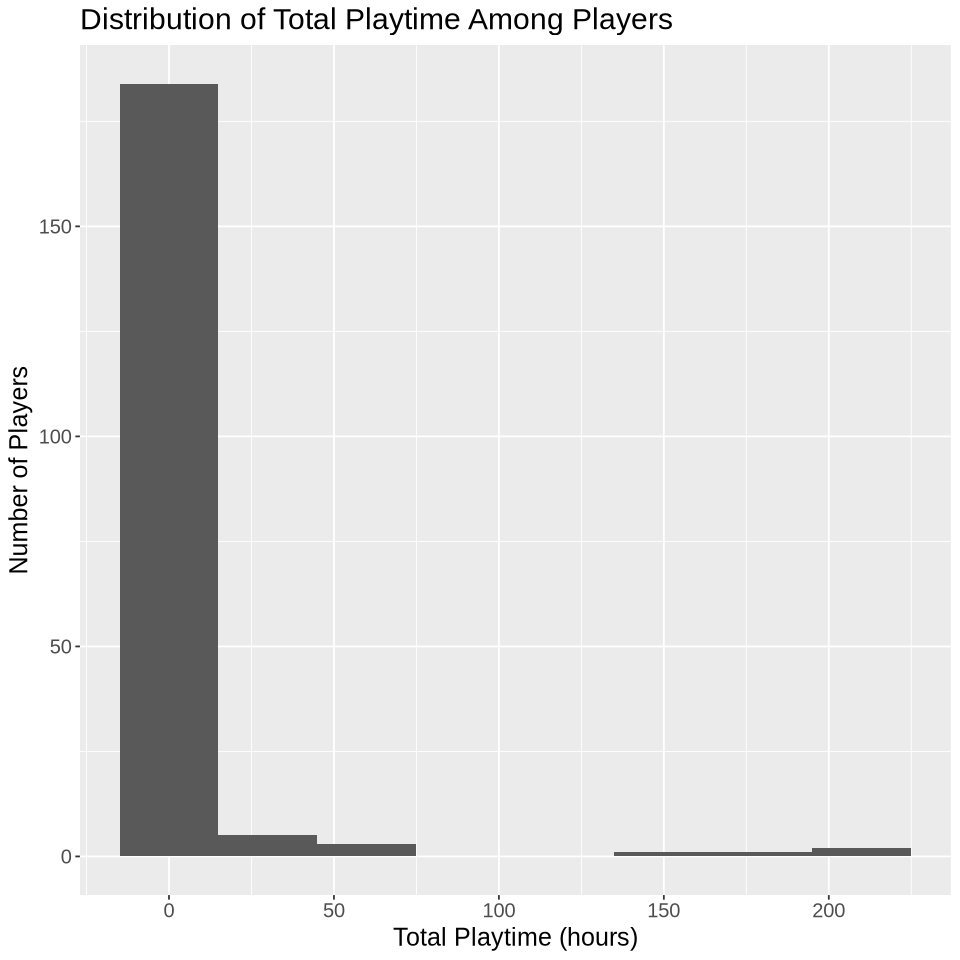

In [5]:
options(repr.plot.width = 8, repr.plot.height = 8)

played_hours_histogram <- players |>
    ggplot(aes(x = played_hours)) +
    geom_histogram(binwidth = 30) +
    labs(
        title = "Distribution of Total Playtime Among Players",
        x = "Total Playtime (hours)",
        y = "Number of Players") +
    theme(text = element_text(size = 15))

played_hours_histogram

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


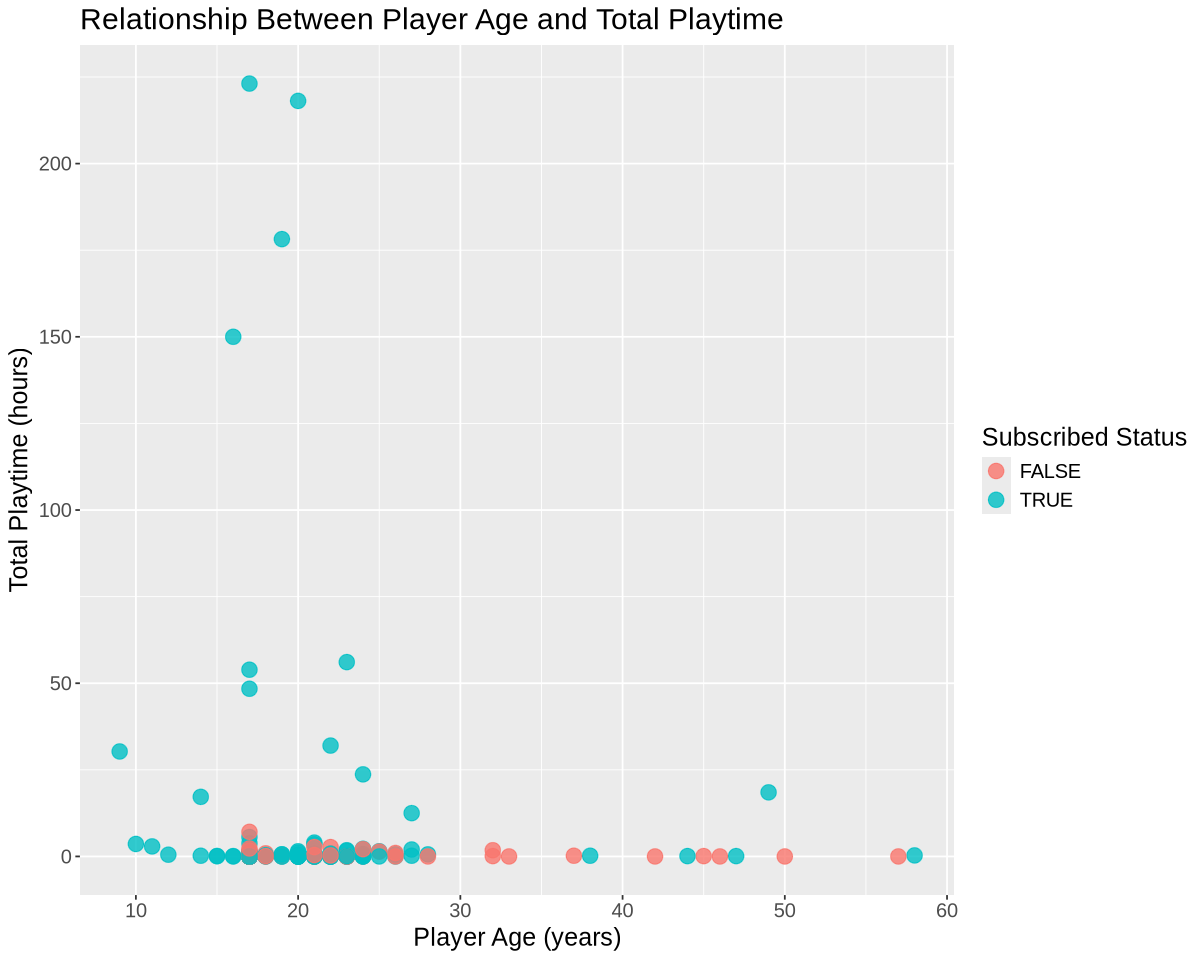

In [6]:
options(repr.plot.width = 10, repr.plot.height = 8)

players_plot <- players |>
    ggplot(aes(x = Age, y = played_hours, color = subscribe)) +
    geom_point(alpha = 0.8, size = 4) +
    labs(
        title = "Relationship Between Player Age and Total Playtime",
        x = "Player Age (years)",
        y = "Total Playtime (hours)",
        color = "Subscribed Status") +
    theme(text = element_text(size = 15))

players_plot

### Insights From Visualizations

The histogram shows that most players recorded very low total playtime, while only a few players spent significantly more time on the server. This right-skewed distribution indicates that overall player engagement is uneven.

The scatter plot reveals that players who subscribed to the newsletter (blue) generally have higher total playtime across multiple age groups, while non-subscribers (red) are concentrated near lower playtime values. This suggests that greater play time, measured by total hours played, may be associated with a higher likelihood of newsletter subscription.

## 4. Methods and Plan

To address the question *"Can a Player's total playtime predict newsletter subscription status?"*, a **K-Nearest Neighbours (KNN) classification** model will be used. The goal is to classify players into `TRUE` or `FALSE` for their `subscription` status based solely on their `played_hours`.

**Why KNN classification:**
- The response variable, `subscribe` is categorical, so classification model has to be chosen over regression model
- The explanatory variable `played_hours` is numeric, which will be used for KNN classification's distance-based comparisons
- KNN is simple, interpretable method that performs well on datasets with relatively small smaples sizes, such as the `players.csv` dataset

<br>

**Assumptions:**
- The K-Nearest Neighbors (KNN) algorithm is a non-parametric method, meaning it makes no assumptions about the underlying data distribution (e.g., normal distribution, linearity)

<br>

**Potential limitations/weaknesses:**
- KNN performance depends heavily on choosing an appropriate value for K, which must be tuned
- If the dataset gets larger, it may lead to computational and memory inefficiency
  
<br>

**How the model will be evaluated, compared and selected:**
- Based on `accuracy` (comparing predicted vs actual subscription status)
- Since there is no cost of false positives (predicting a non-subscriber as a subscriber) or false negative (predicting subscriber as a non-subscriber), neither `precision` or `recall` rate has priority over `accuracy`

<br>

**Data Processing Steps:**
1. Split into training and testing sets using an 75/25 proportion, because the `players.csv` dataset is relatively small and more stable test estimate is desired for this investigation project
2. Splitting will occur before any preprocessing to avoid test set influencing the training process
3. Preprocessing recipe:
    1. Converting `subscribe` to a factor
    2. Scaling and centering `played_hours`
4. Cross-validation (using 5-fold) will be applied to the training set to tune the appropriate value of *K*
5. Final model with the optimal K value will be fitted to the full training set and evaluated on the testing set

## 5. GitHub Repository

GitHub Link: https://github.com/chrislee0530/group_23_individual_project_planning

# Analysis of Data 

Data processing: reading > converting to recipe so both match > recipes, starta = response var. 

In [106]:
library(tidyverse)
library(tidymodels)
set.seed(0001) 

# Read in the raw data from the root directory (same folder) 
players_raw <- read_csv("players.csv") 

# Convert the subscription variable to a factor so it can be used for future analysis
# This will be used for splitting the data. 
players <- players_raw |> 
    mutate(subscription_status = factor(subscribe, 
                                       levels = c(TRUE, FALSE), 
                                       labels = c("Subscribed", "Not Subscribed"))) |> 
    select(-subscribe) 

# Create a split of 75 of the players dataframe, with the response being subscription status

players_split <- initial_split(players, prop = 0.75, strata = subscription_status) 
players_train <- training(players_split) 
players_test <- testing(players_split)

glimpse(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 196
Columns: 7
$ experience          <chr> "Pro", "Veteran", "Veteran", "Amateur", "Regular",…
$ hashedEmail         <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0e…
$ played_hours        <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0,…
$ name                <chr> "Morgan", "Christian", "Blake", "Flora", "Kylie", …
$ gender              <chr> "Male", "Male", "Male", "Female", "Male", "Female"…
$ Age                 <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 47, 22, 23, 17, 25,…
$ subscription_status <fct> Subscribed, Subscribed, Not Subscribed, Subscribed…


now find k, for classification model 

In [132]:
## Recipe with subscription_status as the responding, and played_hours as predictor. 
## We use the training data only , to minimize bias. 
players_recipe <- recipe(subscription_status ~ played_hours, data = players_train) |> 
    step_scale(all_predictors()) |> 
    step_scale(all_predictors()) 

## Specification for model: each point has equal weighting (rectangular) for the classification model.  
## We also set the neighbors argument to tune() to find the optimal k value. 
players_spec_tune <- nearest_neighbor(weight_func  = "rectangular", neighbors = tune()) |> 
    set_engine("kknn")|> 
    set_mode("classification") 

## Create a vfold of 10 to ensure that random sampling doesn't influnence k as much. 
players_vfold <- vfold_cv(players_train, v = 10)


creating the workflow

In [139]:
## Range of neighbors to be tested - set upper bound to 71 to observe tapering. 
grid_vals <- tibble(neighbors = seq(from = 1, to = 71, by = 2)) 

## Workflow to find ideal k value
players_results <- workflow() |> 
    add_recipe(players_recipe) |> 
    add_model(players_spec_tune) |> 
    tune_grid(resamples = players_vfold, grid = grid_vals) |> 
    collect_metrics() 

## Get the accuracies from the player results
accuracies <- players_results |> 
    filter(.metric == "accuracy")





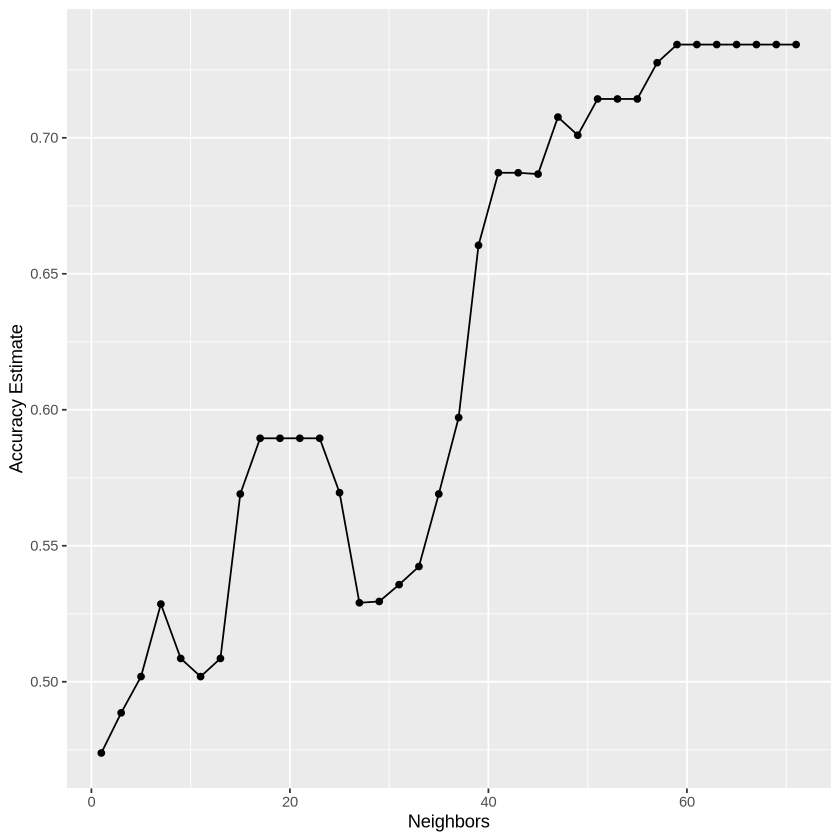

In [140]:
## Create a cross validation plot to find the ideal k value 
# ... NOTE: making the upper bound 71 shows tapering = model guesses the most popular target. 
# Boilerplate from tutorial classification 2 colution
# ... 
cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
                  geom_point() +
                  geom_line() +
                  labs(x = 'Neighbors', y = 'Accuracy Estimate') 
                  # theme(text = element_text(size = 20)) +
                  # scale_x_continuous(breaks = seq(0, 20, 2)) +
                  # scale_y_continuous(limits = c(0.7, 0.85))

cross_val_plot

k = 7

In [143]:
## Create a new predictor model like players_spec but change neighbors (k) to 20 
players_spec_20 <- nearest_neighbor(weight_func = "rectangular", neighbors = 20) |> 
    set_engine("kknn") |> 
    set_mode("classification") 

## Create a fit for players, with the new specification 
players_fit <- workflow() |> 
    add_recipe(players_recipe) |> 
    add_model(players_spec_20) |> 
    fit(data = players_train)

players_fit
    

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_scale()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(20,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.4081633
Best kernel: rectangular
Best k: 20

create predictions, and confusion matrix 

In [145]:
players_predictions <- predict(players_fit, players_test) |> 
    bind_cols(players_test)

players_pred_results <- players_predictions |> 
     metrics(truth = subscription_status, estimate = .pred_class) 

players_conf_mat <- players_predictions |> 
     conf_mat(truth = subscription_status, estimate = .pred_class)

players_pred_results
players_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.48979592
kap,binary,0.04371585


                Truth
Prediction       Subscribed Not Subscribed
  Subscribed             16              5
  Not Subscribed         20              8

## 1.1 Descriptions of `players.csv` Dataset

The `players` dataset contains 196 observations (players) 7 variables and can be further described by the nature of the observation's variables. This dataset gives insight into the demographic of players in the research Minecraft server. The data here is wither qualitative (speaking to the initial state of the player as they joined, current age, experience etc.) or cumulative (time played). Any player's session data found in `session.csv` can be found using the hashemail identifier. 


In [147]:
players <- read_csv("players.csv")
players_observations <- players |> 
    summarise(
        #--- Dataset Observations
        N_players = n(),                                          #Number of players
        #--- Age Observations
        Age_Mean = round(mean(Age, na.rm = TRUE), 2),             #Mean age to 2 sf 
        Age_SD = round(sd(Age, na.rm = TRUE), 2),                 #Standard deviation of age to 2 sf
        Age_Min = min(Age, na.rm = TRUE),                         #Minimum Age (youngest) 
        Age_Median = median(Age, na.rm = TRUE),                   #Median age (most common)
        Age_Max = max(Age, na.rm = TRUE),                         #Maximum age (oldest person)
        #--- Played Hours Observations
        Hours_Mean = round(mean(played_hours, na.rm = TRUE), 2),  #Mean amount of hours played to 2 sf
        Hours_SD = round(sd(played_hours, na.rm = TRUE), 2),      #Standard deviation of hours played to 2 sf
        Hours_Min = min(played_hours, na.rm = TRUE),              #Lowest playtime
        Hours_Median = median(played_hours, na.rm = TRUE),        #Median playtime
        Hours_Max = max(played_hours, na.rm = TRUE)               #Maximum playtime
      )

players_observations 

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


N_players,Age_Mean,Age_SD,Age_Min,Age_Median,Age_Max,Hours_Mean,Hours_SD,Hours_Min,Hours_Median,Hours_Max
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
196,21.14,7.39,9,19,58,5.85,28.36,0,0.1,223.1


`age` is a quantitative data type that describes the player's age.
- The mean age is 21.24 years, the standard deviation of age is 7.39 years
- The median age is 19, the maximum age is 58 years, the minimum age is 9 years. 

`played_hours` is a quantitative data type that totals the amount of cumulative hours a player has been online for.
- The mean session is 5.85 hours, the standard deviation is 28.36 hours.
- The minimum playtime is 0.00 hours, the median playtime is 0.10 hours, and the maximum playtime is 223.10 hours

In [148]:
#Experience Level
experience_summary <- players |>
  group_by(experience) |>
  summarise(Count = n()) |>
  ungroup() |>
  mutate(
    Proportion = round(Count / sum(Count) * 100, 2),
    Proportion_Label = paste0(Proportion, "%")
  ) |>
  arrange(desc(Count))

#Subscription stat
subscribe_summary <- players |>
  group_by(subscribe) |>
  summarise(Count = n()) |>
  ungroup() |>
  mutate(
    Proportion = round(Count / sum(Count) * 100, 2),
    Proportion_Label = paste0(Proportion, "%")
  ) |>
  arrange(desc(Count))

#Gender distrbution
gender_summary <- players |>
  group_by(gender) |>
  summarise(Count = n()) |>
  ungroup() |>
  mutate(
    Proportion = round(Count / sum(Count) * 100, 2),
    Proportion_Label = paste0(Proportion, "%")
  ) |>
  arrange(desc(Count))

experience_summary
subscribe_summary 
print(gender_summary, n=7) #print used to see all gender categories 

experience,Count,Proportion,Proportion_Label
<chr>,<int>,<dbl>,<chr>
Amateur,63,32.14,32.14%
Veteran,48,24.49,24.49%
Regular,36,18.37,18.37%
Beginner,35,17.86,17.86%
Pro,14,7.14,7.14%


subscribe,Count,Proportion,Proportion_Label
<lgl>,<int>,<dbl>,<chr>
TRUE,144,73.47,73.47%
FALSE,52,26.53,26.53%


# A tibble: 7 × 4
  gender            Count Proportion Proportion_Label
  <chr>             <int>      <dbl> <chr>           
1 Male                124      63.3  63.27%          
2 Female               37      18.9  18.88%          
3 Non-binary           15       7.65 7.65%           
4 Prefer not to say    11       5.61 5.61%           
5 Two-Spirited          6       3.06 3.06%           
6 Agender               2       1.02 1.02%           
7 Other                 1       0.51 0.51%           


`experience` is a categorical data type that describes the self proclaimed "experience" level of the player. 
- 63 Amateur players make up 32.14% of the player base.
- 48 Veteran players make up 24.49% of the player base.
- 36 Regular players make up 18.37% of the player base.
- 35 Beginner player make up 17.86% of the player base.
- 35 Beginner players make up 17.86% of the player base. 

`subscribe` is a boolean data type that describes whether the player is subscribed to the game related news letter. 
- 144 of the players are subscribed, making up 73.47% of the player base.
- 52 of the players are not subscribed, and make up the remaining 26.53% of the player base.

`gender` is a categorical data type that describes their gender identity {Male, Female, Non-binary, Prefer not to say, Two-Spirited, Other}
- There are 124 males = 63.27% of the players.
- There are 37 females = 18.88% of the players.
- There are 15 non-binary players = 7.65% of the players.
- There are 11 who prefer no to say = 5.61% of the players.
- There are 6 two-spirit players = 3.06% of the players.
- There are 2 agender players = 1.02% of the players.
- There is 1 person who does not identify with any of the aforementioned categories = 0.51% of players. 

### 1.4 Other Variables
- `hashedEmail` is an identifier data type that is used to ID a player by hashing their email. Summaries cannot really be performed on this without a known hash function (not useful for data analysis in this context). 
- `name` is a string datatype describing the player's first name.